In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import xarray as xr
import iris
import iris.analysis.cartography
import iris.plot as iplt
import iris.coord_categorisation
import iris.analysis.stats
from pathos.threading import ThreadPool as Pool

from scipy.optimize import leastsq
import scipy.stats as spst
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import ListedColormap
import sys
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from f_statistics import *
from f_preprocessing import *
from f_significance_calculation import *

In [4]:
fol='/home/vanoorschot/work/fransje/confess_paper/'

In [5]:
from matplotlib.colors import LinearSegmentedColormap
# colors =['lightgrey','lightgrey','lightgrey']
# cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)
colors2 =['white','white','white']
cmap_white = LinearSegmentedColormap.from_list('cm',colors2, N=3)
colors =['gainsboro','none']
cmap_grey2 = LinearSegmentedColormap.from_list('cm',colors, N=2)
colors =['gainsboro','gainsboro','gainsboro']
cmap_grey = LinearSegmentedColormap.from_list('cm',colors, N=3)

In [6]:
def cmap_map(function, cmap):
    """ Applies function (which should operate on vectors of shape 3: [r, g, b]), on colormap cmap.
    This routine will break any discontinuous points in a colormap.
    """
    cdict = cmap._segmentdata
    step_dict = {}
    # Firt get the list of points where the segments start or end
    for key in ('red', 'green', 'blue'):
        step_dict[key] = list(map(lambda x: x[0], cdict[key]))
    step_list = sum(step_dict.values(), [])
    step_list = np.array(list(set(step_list)))
    # Then compute the LUT, and apply the function to the LUT
    reduced_cmap = lambda step : np.array(cmap(step)[0:3])
    old_LUT = np.array(list(map(reduced_cmap, step_list)))
    new_LUT = np.array(list(map(function, old_LUT)))
    # Now try to make a minimal segment definition of the new LUT
    cdict = {}
    for i, key in enumerate(['red','green','blue']):
        this_cdict = {}
        for j, step in enumerate(step_list):
            if step in step_dict[key]:
                this_cdict[step] = new_LUT[j, i]
            elif new_LUT[j,i] != old_LUT[j, i]:
                this_cdict[step] = new_LUT[j, i]
        colorvector = list(map(lambda x: x + (x[1], ), this_cdict.items()))
        colorvector.sort()
        cdict[key] = colorvector

    return matplotlib.colors.LinearSegmentedColormap('colormap',cdict,1024)

In [7]:
cmap = cm.get_cmap('RdBu', 24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_list[11] = '#ffffff'
color_list[12] = '#ffffff'
cmap_rdbu = ListedColormap(color_list)

In [8]:
cmap = plt.cm.get_cmap('BrBG',24)
color_list = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]
color_list[11] = '#ffffff'
color_list[12] = '#ffffff'
cmap_brbg = ListedColormap(color_list)

In [9]:
tl_0_1 = ['0.0','','0.2','','0.4','','0.6','','0.8','','1.0']
tl_02 = ['-0.20','','-0.12','','-0.04','','0.04','','0.12','','0.20']
tl_01 = ['-0.10','','-0.06','','-0.02','','0.02','','0.06','','0.10']
tl_800=['0','','160','','320','','480','','640','','800']
tl_500=['0','','100','','200','','300','','400','','500']
tl_1500=['0','','300','','600','','900','','1200','','1500']
tl_05=['0.0','','0.1','','0.2','','0.3','','0.4','','0.5']
tl_005=['-0.05','','-0.03','','-0.01','','0.01','','0.03','','0.05']
tl_003=['-0.03','','-0.0015','','0','','0.0015','','0.03']

In [10]:
f_mod = f'{fol}/data/htessel_output/IAK5'
mod = xr.open_dataset(f'{f_mod}/o_veg_1999_2018_climatology.nc')
m = mod.var66.mean(dim='time')
mn = m.notnull()

## LAND COVER

In [11]:
start_year=1999
end_year=2018
name1 = 'CTR'
name2 = 'IALC'
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'

In [12]:
# read icmcl of exp5 (inter annual LAI + LC)
exp5 = xr.open_dataset(f'{fol}/data/exp5_icmcl_yearmean_land2.nc')
cvlt1 = exp5.cvl[0] #cvl in exp7
cvht1 = exp5.cvh[0] #cvl in exp7

cvlt2 = exp5.cvl[:] #cvl in exp6
cvht2 = exp5.cvh[:] #cvl in exp6

if (start_year ==1993):
    cvl_1 = exp5.cvl[14] #1993
else:
    cvl_1 = exp5.cvl[20] #1999

cvl_2 = exp5.cvl[-2] #2019
cvl_diff = cvl_2-cvl_1

if (start_year ==1993):
    cvh_1 = exp5.cvh[14] #1993
else:
    cvh_1 = exp5.cvh[20] #1999

cvh_2 = exp5.cvh[-2] #2019
cvh_diff = cvh_2-cvh_1

cv_1 = cvl_1+cvh_1
cv_2 = cvl_2+cvh_2

if (start_year ==1993):
    tvl_1 = exp5.tvl[14]
    tvh_1 = exp5.tvh[14]
else:
    tvl_1 = exp5.tvl[20]
    tvh_1 = exp5.tvh[20]

tvl_1 = tvl_1.where(tvl_1>0)
tvh_1 = tvh_1.where(tvh_1>0)

tvl_2 = exp5.tvl[-2]
tvh_2 = exp5.tvh[-2]
tvl_2 = tvl_2.where(tvl_2>0)
tvh_2 = tvh_2.where(tvh_2>0)

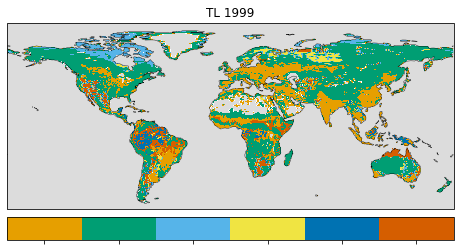

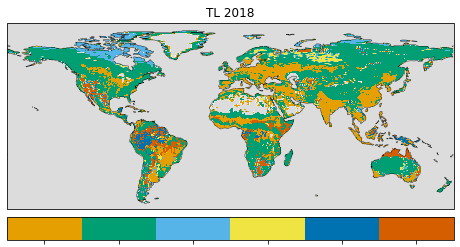

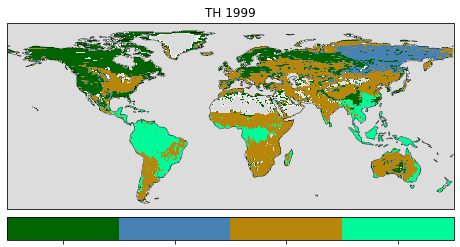

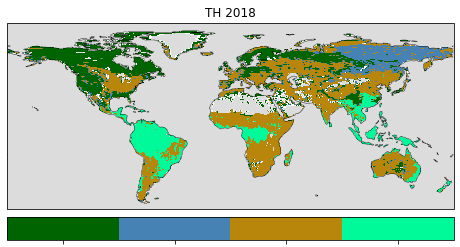

In [13]:
# land cover maps
cm = plt.cm.get_cmap('tab20b')
lvls=[1,2,3,4,5,6,7,8.5,10,11,12.5,15,17,18,19,20]
lvls2 = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,9.5,10.5,11.5,13.5,16.5,17.5,18.5,19.5,20.5]
tick_lb=[1,2,3,4,5,6,7,9,10,11,12,16,17,18,19,20]

# TVL COLOR BAR
lvls=[1,2,6,11.5,15,17]
lvls2 = [0.5,1.5,2.5,9.5,13.5,16.5,17.5]
tick_lb=[1,2,9,13,16,17]

c2=(230/255,159/255,0/255)
c3=(86/255,180/255,233/255)
c4=(0/255,158/255,115/255)
c5=(240/255,228/255,66/255)
c6=(0/255,114/255,178/255)
c7=(213/255,94/255,0/255)
c8=(204/255,121/255,167/255)
c = ['white',c2,c4,c3,c5,c6,c7]
cml = ListedColormap(c)

# TVL
n = tvl_1.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = tvl_1.plot(ax=ax, cmap=cml, add_colorbar=False, vmin=0.5, vmax=20, levels=lvls2)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither', pad=0.02, ticks = lvls)
cbar.ax.tick_params(labelsize=14)
cbar.set_ticklabels('')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
ax.set_title(f'TL {start_year}')
# ax.set_xlim(-12,60)
# ax.set_ylim(35,80)
fig.savefig(f'{fol}/output_figures/landcover/tvl_{start_year}.jpg',dpi=300,bbox_inches='tight')

# TVL
n = tvl_2.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = tvl_2.plot(ax=ax, cmap=cml, add_colorbar=False, vmin=0.5, vmax=20, levels=lvls2)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither', pad=0.02, ticks = lvls)
cbar.ax.tick_params(labelsize=14)
cbar.set_ticklabels('')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
ax.set_title(f'TL {end_year}')
# ax.set_xlim(-12,60)
# ax.set_ylim(35,80)
fig.savefig(f'{fol}/output_figures/landcover/tvl_{end_year}.jpg',dpi=300,bbox_inches='tight')

# TVH COLOR BAR
lvls=[3,4,5,6]
lvls2 = [2.5,3.5,4.5,5.5,6.5]
tick_lb=[3,4,5,6]
ch = ['white','darkgreen','steelblue','darkgoldenrod','mediumspringgreen']
# ch = color_list[7:]
cmh = ListedColormap(ch)

# TVH
n = tvh_1.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = tvh_1.plot(ax=ax, cmap=cmh, add_colorbar=False, vmin=0.5, vmax=20, levels=lvls2)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither', pad=0.02, ticks = lvls)
cbar.set_ticklabels('')
cbar.ax.tick_params(labelsize=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
ax.set_title(f'TH {start_year}')
# ax.set_xlim(-12,60)
# ax.set_ylim(35,80)
fig.savefig(f'{fol}/output_figures/landcover/tvh_{start_year}.jpg',dpi=300,bbox_inches='tight')

n = tvh_2.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = tvh_2.plot(ax=ax, cmap=cmh, add_colorbar=False, vmin=0.5, vmax=20, levels=lvls2)
cbar = plt.colorbar(cf, orientation='horizontal',extend='neither', pad=0.02, ticks = lvls)
cbar.set_ticklabels('')
cbar.ax.tick_params(labelsize=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
ax.set_title(f'TH {end_year}')
# ax.set_xlim(-12,60)
# ax.set_ylim(35,80)
fig.savefig(f'{fol}/output_figures/landcover/tvh_{end_year}.jpg',dpi=300,bbox_inches='tight')

In [14]:
lowerh=[0.5,3.5,4.5,5.5]
upperh=[3.5,4.5,5.5,6.5]

lowerl=[0,1.5,2.5,11.5,14.5,16.5]
upperl=[1.5,2.5,11.5,14.5,16.5,20]

In [15]:
dfh = pd.DataFrame(index=[3,4,5,6],columns=['replaced','replaces','amount of points 1999','amount of points 2019'])
for i in range(len(lowerh)):
    # REPLACED
    tvh_1_i = tvh_1.where((tvh_1>lowerh[i])&(tvh_1<upperh[i])) # mask veg type 1999
    tvh_2_i = tvh_2.where((tvh_1>lowerh[i])&(tvh_1<upperh[i])) # mask veg type of 2019 with 1999 mask

    tvh_1_is = tvh_1_i.stack(dim=['lat','lon']).values # stack 1999
    tvh_1_isn = tvh_1_is[~np.isnan(tvh_1_is)] # remove nan points 1999
    tvh_2_is = tvh_2_i.stack(dim=['lat','lon']).values # stack 2019
    tvh_2_isn = tvh_2_is[~np.isnan(tvh_2_is)] # remove nan points 2019
    tvh_2_isnv = tvh_2_isn[(tvh_2_isn>lowerh[i])&(tvh_2_isn<upperh[i])]

    l1 = len(tvh_1_isn) # count points in 1999
    l2 = len(tvh_2_isnv) # count points in 2019

    l_replaced = l1-l2 # difference in points is points replaced
    # print(l_replaced)
    dfh.iloc[i,0]=l_replaced

    # REPLACES
    tvh_2_i = tvh_2.where((tvh_2>lowerh[i])&(tvh_2<upperh[i])) # mask veg type 2019
    tvh_1_i = tvh_1.where((tvh_2>lowerh[i])&(tvh_2<upperh[i])) # mask veg type of 1999 with 2019 mask

    tvh_1_is = tvh_1_i.stack(dim=['lat','lon']).values # stack 1999
    tvh_1_isn = tvh_1_is[~np.isnan(tvh_1_is)] # remove nan points 1999
    tvh_1_isnv = tvh_1_isn[(tvh_1_isn>lowerh[i])&(tvh_1_isn<upperh[i])]
    tvh_2_is = tvh_2_i.stack(dim=['lat','lon']).values # stack 2019
    tvh_2_isn = tvh_2_is[~np.isnan(tvh_2_is)] # remove nan points 2019

    l1 = len(tvh_1_isnv) # count points in 1999
    l2 = len(tvh_2_isn) # count points in 2019

    l_replaces = l2-l1 # difference in points is points replacing
    # print(l_replaces)
    dfh.iloc[i,1]=l_replaces
    dfh.iloc[i,2]=l1
    dfh.iloc[i,3]=l2
    

In [16]:
dfl = pd.DataFrame(index=[1,2,9,13,16,17],columns=['replaced','replaces','amount of points 1999','amount of points 2019'])
for i in range(len(lowerl)):
    # REPLACED
    tvl_1_i = tvl_1.where((tvl_1>lowerl[i])&(tvl_1<upperl[i])) # mask veg type 1999
    tvl_2_i = tvl_2.where((tvl_1>lowerl[i])&(tvl_1<upperl[i])) # mask veg type of 2019 with 1999 mask

    tvl_1_is = tvl_1_i.stack(dim=['lat','lon']).values # stack 1999
    tvl_1_isn = tvl_1_is[~np.isnan(tvl_1_is)] # remove nan points 1999
    tvl_2_is = tvl_2_i.stack(dim=['lat','lon']).values # stack 2019
    tvl_2_isn = tvl_2_is[~np.isnan(tvl_2_is)] # remove nan points 2019
    tvl_2_isnv = tvl_2_isn[(tvl_2_isn>lowerl[i])&(tvl_2_isn<upperl[i])]

    l1 = len(tvl_1_isn) # count points in 1999
    l2 = len(tvl_2_isnv) # count points in 2019
    dfl.iloc[i,2]=l1
    
    l_replaced = l1-l2 # difference in points is points replaced
    # print(l_replaced)
    dfl.iloc[i,0]=l_replaced

    # REPLACES
    tvl_2_i = tvl_2.where((tvl_2>lowerl[i])&(tvl_2<upperl[i])) # mask veg type 2019
    tvl_1_i = tvl_1.where((tvl_2>lowerl[i])&(tvl_2<upperl[i])) # mask veg type of 1999 with 2019 mask

    tvl_1_is = tvl_1_i.stack(dim=['lat','lon']).values # stack 1999
    tvl_1_isn = tvl_1_is[~np.isnan(tvl_1_is)] # remove nan points 1999
    tvl_1_isnv = tvl_1_isn[(tvl_1_isn>lowerl[i])&(tvl_1_isn<upperl[i])]
    tvl_2_is = tvl_2_i.stack(dim=['lat','lon']).values # stack 2019
    tvl_2_isn = tvl_2_is[~np.isnan(tvl_2_is)] # remove nan points 2019

    l1 = len(tvl_1_isnv) # count points in 1999
    l2 = len(tvl_2_isn) # count points in 2019

    l_replaces = l2-l1 # difference in points is points replacing
    # print(l_replaces)
    dfl.iloc[i,1]=l_replaces
    dfl.iloc[i,3]=l2
    

In [17]:
# use total points for fractions
df = pd.concat([dfl,dfh])
lp = tvh_1.stack(dim=['lat','lon']).values
k = lp[~np.isnan(lp)]
dfr = df/len(k)* 100
dfr['vegtypes']=dfr.index
dfr.index = [1,2,3,4,5,6,7,8,9,10]
dfr

,replaced,replaces,amount of points 1999,amount of points 2019,vegtypes
1,0.589065,1.029982,26.056437,26.497354,1
2,1.171076,1.45679,53.326279,53.611993,2
3,0.80776,0.634921,9.347443,9.174603,9
4,0.493827,0.261023,2.835979,2.603175,13
5,0.359788,0.27866,3.089947,3.008818,16
6,0.645503,0.328042,6.910053,6.592593,17
7,1.082892,0.878307,29.978836,30.857143,3
8,0.864198,1.058201,11.996473,13.054674,4
9,1.238095,1.118166,39.121693,40.239859,5
10,0.257496,0.194004,14.0,14.194004,6


In [18]:
# use percentages of veg type occurrence for fractions
dfr2 = pd.concat([dfl,dfh])
# dfr = df/len(tvh_2.stack(dim=['lat','lon']).values) * 100
dfr2['vegtypes']=dfr2.index
dfr2.index = [1,2,3,4,5,6,7,8,9,10]
dfr2['replaced_frac'] = dfr2['replaced']/dfr2['amount of points 1999'] * 100
dfr2['replaces_frac'] = dfr2['replaces']/dfr2['amount of points 1999'] * 100
dfr2

,replaced,replaces,amount of points 1999,amount of points 2019,vegtypes,replaced_frac,replaces_frac
1,167,292,7387,7512,1,2.260728,3.95289
2,332,413,15118,15199,2,2.196058,2.731843
3,229,180,2650,2601,9,8.641509,6.792453
4,140,74,804,738,13,17.412935,9.20398
5,102,79,876,853,16,11.643836,9.018265
6,183,93,1959,1869,17,9.341501,4.74732
7,307,249,8499,8748,3,3.61219,2.929756
8,245,300,3401,3701,4,7.203764,8.820935
9,351,317,11091,11408,5,3.164728,2.858173
10,73,55,3969,4024,6,1.839254,1.385739


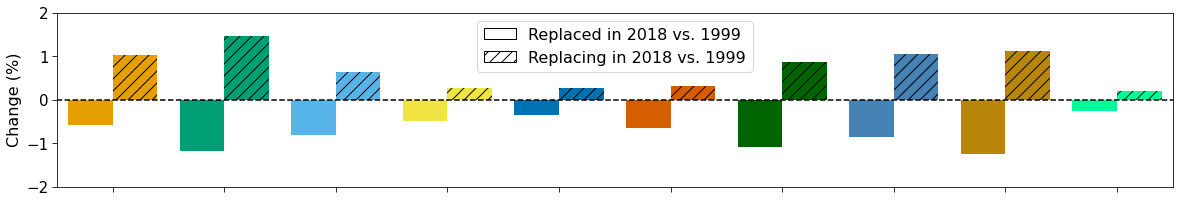

In [19]:
# replacing/replaced using percentages per vegtype
cl = [c2,c4,c3,c5,c6,c7]
ch = ['darkgreen','steelblue','darkgoldenrod','mediumspringgreen']
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

fig = plt.figure(figsize=(20,3.2))
ax = fig.add_subplot(111)
bins_l = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]
bins_h = [6.5,7.5,8.5,9.5,10.5]
for i in range(6):
    ax.bar(dfr.index[i]-0.2,dfr.iloc[i].replaced*-1,width=0.4,color=cl[i])
    ax.bar(dfr.index[i]+0.2,dfr.iloc[i].replaces,width=0.4,color=cl[i],hatch='//')

for j in range(4):
    ax.bar(dfr.index[j+6]-0.2,dfr.iloc[j+6].replaced*-1,width=0.4,color=ch[j])
    ax.bar(dfr.index[j+6]+0.2,dfr.iloc[j+6].replaces,width=0.4,color=ch[j],hatch='//')
ax.hlines(0,0,11, linestyle='--',color='k')
ax.bar(-1,1,width=0.1,color='white',label='Replaced in 2018 vs. 1999')
ax.bar(-2,1,width=0.1,color='white',hatch='//',label='Replacing in 2018 vs. 1999')
ax.set_xlim(0.5,10.5)
ax.set_ylim(-2,2)
ax.tick_params(axis='y', which='major',length=5, labelsize=15)
ax.tick_params(axis='x', which='major',length=5, labelsize=15)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
# ax.set_xticklabels([1,2,9,13,16,17,3,4,5,6],size=15)
ax.set_xticklabels([])
# ax.set_xticklabels(['Crops','Short grass','Tundra','Bogs and marshes','Evergreen shrubs','Deciduous shrubs','Evergreen needleleaf trees','Deciduous needleleaf trees','Deciduous broadleaf trees','Evergreen needleleaf trees'],
                   # rotation=30)
ax.set_ylabel('Change (%)',size=16)
# ax.set_xlabel('Vegetation type indices',size=15)
leg = ax.legend(fontsize=16,ncol=1)
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_edgecolor('k')
fig.savefig(f'{fol}/output_figures/landcover/histogram_fractions_{start_year}_{end_year}.jpg',dpi=300,bbox_inches='tight')

In [20]:
# how many points change in veg type???
tvhd = tvh_2 - tvh_1 # diff

#TVH
# all points
tvh_s = tvhd.stack(dim=['lat','lon']).values
tvh_s2 = tvh_s[~np.isnan(tvh_s)]
tvh_t = len(tvh_s2)

# changed points
tvhd2 = tvhd.where(tvhd!=0, drop=True)
tvhd_s = tvhd2.stack(dim=['lat','lon']).values
tvhd_s2 = tvhd_s[~np.isnan(tvhd_s)]
tvh_c = len(tvhd_s2)
tvh_p = tvh_c/tvh_t * 100

#TVL
tvld = tvl_2 - tvl_1 # diff
# all points
tvl_s = tvld.stack(dim=['lat','lon']).values
tvl_s2 = tvl_s[~np.isnan(tvl_s)]
tvl_t = len(tvl_s2)

# changed points
tvld2 = tvld.where(tvld!=0, drop=True)
tvld_s = tvld2.stack(dim=['lat','lon']).values
tvld_s2 = tvld_s[~np.isnan(tvld_s)]
tvl_c = len(tvld_s2)
tvl_p = tvl_c/tvl_t * 100

print(f'TVH changes in {tvh_c}/{tvh_t} = {tvh_p}% points')
print(f'TVL changes in {tvl_c}/{tvl_t} = {tvl_p}% points')

TVH changes in 1399/28291 = 4.945035523664769% points
TVL changes in 1436/28933 = 4.963190820170739% points


In [21]:
# AMAZON BOX
lat_minb_az,lat_maxb_az = -14,-8.5
lon_minb2_az,lon_maxb2_az = 295,310
lon_minb_az = lon_minb2_az-360
lon_maxb_az = lon_maxb2_az-360
lat_minb_az2,lat_maxb_az2 = lat_minb_az-3,lat_maxb_az+3 #larger box for visualization in maps
lon_minb_az2,lon_maxb_az2 = lon_minb_az-3,lon_maxb_az+3 #larger box for visualization in maps

# LAPLAND BOX
lat_minb_lp,lat_maxb_lp = 66.5,71
lon_minb2_lp,lon_maxb2_lp = 25,40
lon_minb_lp = lon_minb2_lp
lon_maxb_lp = lon_maxb2_lp
lat_minb_lp2,lat_maxb_lp2 = lat_minb_lp-3,lat_maxb_lp+3 #larger box for visualization in maps
lon_minb_lp2,lon_maxb_lp2 = lon_minb_lp-3,lon_maxb_lp+3 #larger box for visualization in maps

# CENTRAL ASIA BOX
lat_minb_as,lat_maxb_as = 46,51
lon_minb2_as,lon_maxb2_as = 55,85
lon_minb_as = lon_minb2_as
lon_maxb_as = lon_maxb2_as
lat_minb_as2,lat_maxb_as2 = lat_minb_as-3,lat_maxb_as+3 #larger box for visualization in maps
lon_minb_as2,lon_maxb_as2 = lon_minb_as-3,lon_maxb_as+3 #larger box for visualization in maps

In [22]:
az_cvl1 = cvl_1.where((cvl_1.lat>lat_minb_az)&(cvl_1.lat<lat_maxb_az)&(cvl_1.lon>lon_minb2_az)&(cvl_1.lon<lon_maxb2_az))
az_cvl1 = az_cvl1.mean(dim=['lat','lon']).values
az_cvl2 = cvl_2.where((cvl_2.lat>lat_minb_az)&(cvl_2.lat<lat_maxb_az)&(cvl_2.lon>lon_minb2_az)&(cvl_2.lon<lon_maxb2_az))
az_cvl2 = az_cvl2.mean(dim=['lat','lon']).values

az_cvh1 = cvh_1.where((cvh_1.lat>lat_minb_az)&(cvh_1.lat<lat_maxb_az)&(cvh_1.lon>lon_minb2_az)&(cvh_1.lon<lon_maxb2_az))
az_cvh1 = az_cvh1.mean(dim=['lat','lon']).values
az_cvh2 = cvh_2.where((cvh_2.lat>lat_minb_az)&(cvh_2.lat<lat_maxb_az)&(cvh_2.lon>lon_minb2_az)&(cvh_2.lon<lon_maxb2_az))
az_cvh2 = az_cvh2.mean(dim=['lat','lon']).values

lp_cvl1 = cvl_1.where((cvl_1.lat>lat_minb_lp)&(cvl_1.lat<lat_maxb_lp)&(cvl_1.lon>lon_minb2_lp)&(cvl_1.lon<lon_maxb2_lp))
lp_cvl1 = lp_cvl1.mean(dim=['lat','lon']).values
lp_cvl2 = cvl_2.where((cvl_2.lat>lat_minb_lp)&(cvl_2.lat<lat_maxb_lp)&(cvl_2.lon>lon_minb2_lp)&(cvl_2.lon<lon_maxb2_lp))
lp_cvl2 = lp_cvl2.mean(dim=['lat','lon']).values

lp_cvh1 = cvh_1.where((cvh_1.lat>lat_minb_lp)&(cvh_1.lat<lat_maxb_lp)&(cvh_1.lon>lon_minb2_lp)&(cvh_1.lon<lon_maxb2_lp))
lp_cvh1 = lp_cvh1.mean(dim=['lat','lon']).values
lp_cvh2 = cvh_2.where((cvh_2.lat>lat_minb_lp)&(cvh_2.lat<lat_maxb_lp)&(cvh_2.lon>lon_minb2_lp)&(cvh_2.lon<lon_maxb2_lp))
lp_cvh2 = lp_cvh2.mean(dim=['lat','lon']).values

as_cvl1 = cvl_1.where((cvl_1.lat>lat_minb_as)&(cvl_1.lat<lat_maxb_as)&(cvl_1.lon>lon_minb2_as)&(cvl_1.lon<lon_maxb2_as))
as_cvl1 = as_cvl1.mean(dim=['lat','lon']).values
as_cvl2 = cvl_2.where((cvl_2.lat>lat_minb_as)&(cvl_2.lat<lat_maxb_as)&(cvl_2.lon>lon_minb2_as)&(cvl_2.lon<lon_maxb2_as))
as_cvl2 = as_cvl2.mean(dim=['lat','lon']).values

as_cvh1 = cvh_1.where((cvh_1.lat>lat_minb_as)&(cvh_1.lat<lat_maxb_as)&(cvh_1.lon>lon_minb2_as)&(cvh_1.lon<lon_maxb2_as))
as_cvh1 = as_cvh1.mean(dim=['lat','lon']).values
as_cvh2 = cvh_2.where((cvh_2.lat>lat_minb_as)&(cvh_2.lat<lat_maxb_as)&(cvh_2.lon>lon_minb2_as)&(cvh_2.lon<lon_maxb2_as))
as_cvh2 = as_cvh2.mean(dim=['lat','lon']).values

df = pd.DataFrame(index=['az','lp','as'],columns=['al1','al2','ah1','ah2'])
df.loc['az'] = [az_cvl1,az_cvl2,az_cvh1,az_cvh2]
df.loc['lp'] = [lp_cvl1,lp_cvl2,lp_cvh1,lp_cvh2]
df.loc['as'] = [as_cvl1,as_cvl2,as_cvh1,as_cvh2]
df

,al1,al2,ah1,ah2
az,0.36380515,0.42862865,0.6356411,0.57054657
lp,0.6259689,0.5770508,0.24302433,0.30176106
as,0.6593439,0.7180456,0.06262772,0.063282855


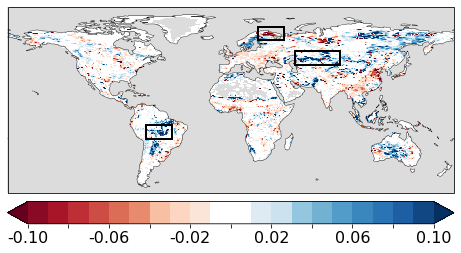

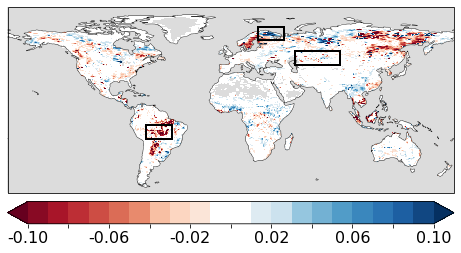

In [23]:
# plot vegetation fractional cover difference 

n = cvl_diff.notnull()
fig = plt.figure(figsize=(8,8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(-0.1,0.1,21)
lvls2 = np.linspace(-0.1,0.1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvl_diff.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_01)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
# ax.set_ylim(30,75)
# ax.set_xlim(45,125)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
fig.savefig(f'{fol}/output_figures/landcover/al_diff_{end_year}-{start_year}_boxes.jpg',dpi=300,bbox_inches='tight')

n = cvh_diff.notnull()
fig = plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('BrBG')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(-0.1,0.1,21)
lvls2 = np.linspace(-0.1,0.1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvh_diff.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_01)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
# ax.set_ylim(30,75)
# ax.set_xlim(45,125)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
fig.savefig(f'{fol}/output_figures/landcover/ah_diff_{end_year}-{start_year}_boxes.jpg',dpi=300,bbox_inches='tight')

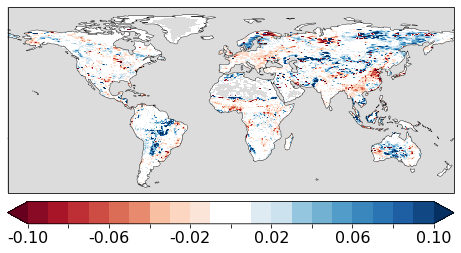

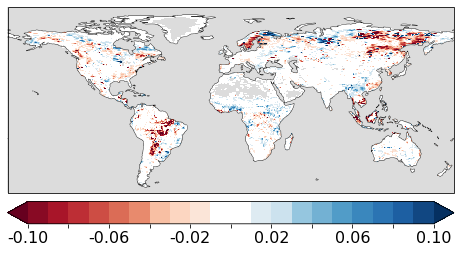

In [24]:
# plot vegetation fractional cover difference 

n = cvl_diff.notnull()
fig = plt.figure(figsize=(8,8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(-0.1,0.1,21)
lvls2 = np.linspace(-0.1,0.1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvl_diff.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_01)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
# ax.set_xlim(100,160)
# ax.set_ylim(-40,-20)
fig.savefig(f'{fol}/output_figures/landcover/al_diff_{end_year}-{start_year}_nopoints.jpg',dpi=300,bbox_inches='tight')

n = cvh_diff.notnull()
fig = plt.figure(figsize=(8,8))
cm = plt.cm.get_cmap('BrBG')
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(-0.1,0.1,21)
lvls2 = np.linspace(-0.1,0.1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvh_diff.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_01)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
# ax.set_xlim(100,160)
# ax.set_ylim(-40,-20)
fig.savefig(f'{fol}/output_figures/landcover/ah_diff_{end_year}-{start_year}_nopoints.jpg',dpi=300,bbox_inches='tight')

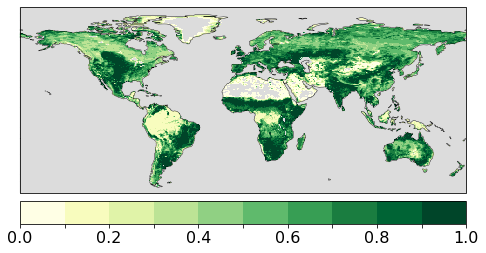

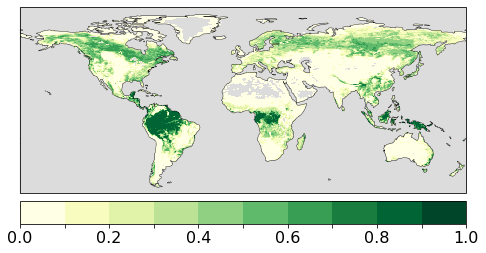

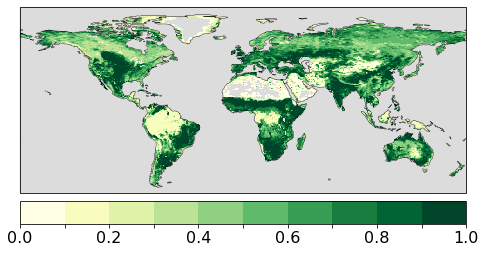

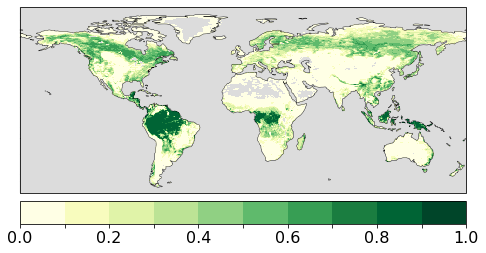

In [25]:
# plot vegetation fractional coverage absolute 
cmap_ylgn = plt.cm.get_cmap('YlGn')

n = cvl_2.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(0,1,11)
lvls2 = np.linspace(0,1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvl_2.plot(ax=ax, cmap=cmap_ylgn, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/al_{end_year}.jpg',dpi=300,bbox_inches='tight')

n = cvh_2.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(0,1,11)
lvls2 = np.linspace(0,1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvh_2.plot(ax=ax, cmap=cmap_ylgn, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/ah_{end_year}.jpg',dpi=300,bbox_inches='tight')

n = cvl_1.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(0,1,11)
lvls2 = np.linspace(0,1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvl_1.plot(ax=ax, cmap=cmap_ylgn, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/al_{start_year}.jpg',dpi=300,bbox_inches='tight')

n = cvh_1.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(0,1,11)
lvls2 = np.linspace(0,1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvh_1.plot(ax=ax, cmap=cmap_ylgn, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/ah_{start_year}.jpg',dpi=300,bbox_inches='tight')

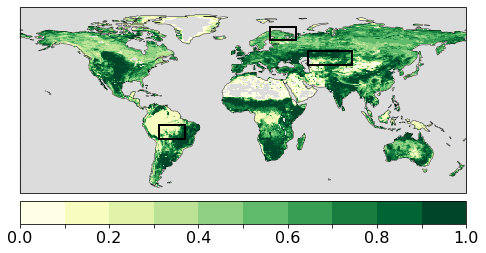

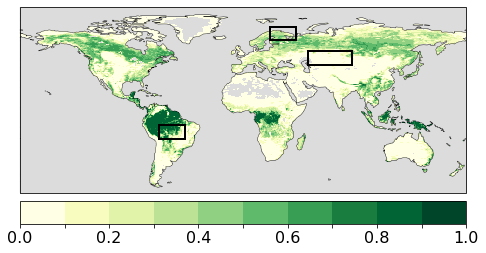

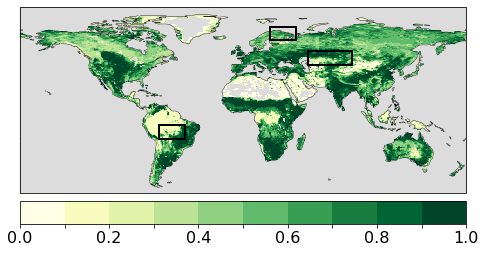

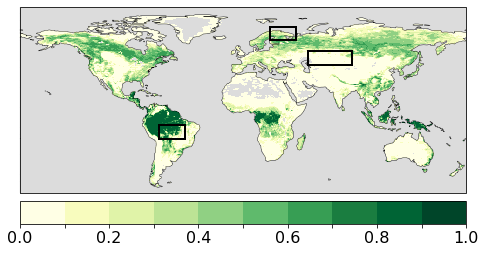

In [26]:
# plot vegetation fractional coverage absolute - boxes
cmap_ylgn = plt.cm.get_cmap('YlGn')

n = cvl_2.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(0,1,11)
lvls2 = np.linspace(0,1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvl_2.plot(ax=ax, cmap=cmap_ylgn, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/al_{end_year}_boxes.jpg',dpi=300,bbox_inches='tight')

n = cvh_2.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(0,1,11)
lvls2 = np.linspace(0,1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvh_2.plot(ax=ax, cmap=cmap_ylgn, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/ah_{end_year}_boxes.jpg',dpi=300,bbox_inches='tight')

n = cvl_1.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(0,1,11)
lvls2 = np.linspace(0,1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvl_1.plot(ax=ax, cmap=cmap_ylgn, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/al_{start_year}_boxes.jpg',dpi=300,bbox_inches='tight')

n = cvh_1.notnull()
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
lvls = np.linspace(0,1,11)
lvls2 = np.linspace(0,1,11)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = cvh_1.plot(ax=ax, cmap=cmap_ylgn, add_colorbar=False, vmin=0, vmax=10, levels=lvls)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar = plt.colorbar(cf, orientation='horizontal', label=f'', pad=0.02, ticks = lvls2)
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xticklabels(tl_0_1)
ax.set_title(f'')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/ah_{start_year}_boxes.jpg',dpi=300,bbox_inches='tight')

## EFFECTS ON MODEL

In [27]:
start_year=1999
end_year=2018
exp_name1='exp3'
exp_name2='ex10'
name1 = 'CTR'
name2 = 'IALC'
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
from matplotlib import cm

In [28]:
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
name1='CTR'
name2='IALC'

et1 = mod1.TVEG * -1000
es1 = mod1.ESOIL * -1000
e1 = mod1.E * -1000
ei1 = mod1.evatc * -1000

et2 = mod2.TVEG * -1000
es2 = mod2.ESOIL * -1000
e2 = mod2.E * -1000
ei2 = mod2.evatc * -1000

etm1 = et1.mean(dim='time')*365
esm1 = es1.mean(dim='time')*365
eim1 = ei1.mean(dim='time')*365
em1 = e1.mean(dim='time')*365

etm2 = et2.mean(dim='time')*365
esm2 = es2.mean(dim='time')*365
eim2 = ei2.mean(dim='time')*365
em2 = e2.mean(dim='time')*365

etm1 = etm1.where(etm1>0.1)
esm1 = esm1.where(esm1>0.1)
eim1 = eim1.where(eim1>0.1)
em1 = em1.where(em1>0.1)

etmask = etm1.where(etm1>0.1)
esmask = esm1.where(esm1>0.1)
eimask = eim1.where(eim1>0.1)
emask = em1.where(em1>0.1)

et_c = (etm2-etm1)/etm1
es_c = (esm2-esm1)/esm1
ei_c = (eim2-eim1)/eim1
e_c = (em2-em1)/em1

ref_data = 'DOLCE_v3'
fol_ref = f'{fol}/data/ref_data/'
ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}.nc')
ref = ref.hfls/28.94 # from w/m2 to mm/day
em_dolce = ref.mean(dim=['time'])*365

### EVAPORATION - boxes

In [29]:
def e_boxes(name1,name2,lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
    name1='CTR'
    name2='IALC'

    et1 = mod1.TVEG * -1000
    es1 = mod1.ESOIL * -1000
    e1 = mod1.E * -1000
    ei1 = mod1.evatc * -1000

    et2 = mod2.TVEG * -1000
    es2 = mod2.ESOIL * -1000
    e2 = mod2.E * -1000
    ei2 = mod2.evatc * -1000

    etm1 = et1.mean(dim=['lat','lon','time']).values*365
    esm1 = es1.mean(dim=['lat','lon','time']).values*365
    eim1 = ei1.mean(dim=['lat','lon','time']).values*365
    em1 = e1.mean(dim=['lat','lon','time']).values*365

    etm2 = et2.mean(dim=['lat','lon','time']).values*365
    esm2 = es2.mean(dim=['lat','lon','time']).values*365
    eim2 = ei2.mean(dim=['lat','lon','time']).values*365
    em2 = e2.mean(dim=['lat','lon','time']).values*365

#     etm1 = etm1.where(etm1>0.1)
#     esm1 = esm1.where(esm1>0.1)
#     eim1 = eim1.where(eim1>0.1)
#     em1 = em1.where(em1>0.1)

#     etmask = etm1.where(etm1>0.1)
#     esmask = esm1.where(esm1>0.1)
#     eimask = eim1.where(eim1>0.1)
#     emask = em1.where(em1>0.1)

    et_c = (etm2-etm1)/etm1
    es_c = (esm2-esm1)/esm1
    ei_c = (eim2-eim1)/eim1
    e_c = (em2-em1)/em1
    return int(em1),int(em2),int(etm1),int(etm2),int(esm1),int(esm2),int(eim1),int(eim2),np.round(e_c,3),np.round(et_c,3),np.round(es_c,3),np.round(ei_c,3)

In [30]:
az = e_boxes(name1,name2,lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = e_boxes(name1,name2,lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = e_boxes(name1,name2,lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)

df = pd.DataFrame(index=['az','lp','as'],columns=['em1','em2','etm1','etm2','esm1','esm2','eim1','eim2','e_c','et_c','es_c','ei_c'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass
df

,em1,em2,etm1,etm2,esm1,esm2,eim1,eim2,e_c,et_c,es_c,ei_c
az,1161,1151,621,606,153,176,386,368,-0.009,-0.024,0.148,-0.047
lp,199,202,42,46,117,115,37,38,0.015,0.098,-0.022,0.027
as,281,281,27,28,226,225,14,14,0.001,0.028,-0.004,0.026


In [31]:
def e_boxes_dolce(lat_min,lat_max,lon_min,lon_max):
    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data/'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}.nc')
    ref = ref.hfls/28.94 # from w/m2 to mm/day
    ref = ref.where((ref.lat>lat_min)&(ref.lat<lat_max)&(ref.lon>lon_min)&(ref.lon<lon_max))
    
    e_m = ref.mean(dim=['lat','lon','time']).values*365
    return(int(e_m))

In [32]:
az = e_boxes_dolce(lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = e_boxes_dolce(lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = e_boxes_dolce(lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)
df = pd.DataFrame(index=['az','lp','as'],columns=['e_dolcev3m'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass

df

,e_dolcev3m
az,1156
lp,252
as,276


In [33]:
def r_e_boxes(lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))

    mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
   
    e1 = mod1.E * -1000
    e2 = mod2.E * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_ia_anomalies.nc')
    ref = ref.where((ref.lat>lat_min)&(ref.lat<lat_max)&(ref.lon>lon_min)&(ref.lon<lon_max))
    ref = ref.hfls/28.94 # from w/m2 to mm/day

    r1 = LE_corr(e1,ref).mean(dim=['lat','lon']).values
    r2 = LE_corr(e2,ref).mean(dim=['lat','lon']).values
    rd = r1-r2

    return np.round(r1,3),np.round(r2,3),np.round(rd,3)

In [34]:
def r_sms_boxes(lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))

    mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
   
    sm1 = mod1.SWVL1
    sm2 = mod2.SWVL1

    smfol=f'{fol}/data/ref_data'
    esa=xr.open_dataset(f'{smfol}/ESACCI-SOILMOISTURE-1999-2018-ia_anomalies.nc')
    esa = esa.where((esa.lat>lat_min)&(esa.lat<lat_max)&(esa.lon>lon_min)&(esa.lon<lon_max))
    esa=esa.sm

    r1 = LE_corr(e1,esa).mean(dim=['lat','lon'],skipna=True).values
    r2 = LE_corr(e2,esa).mean(dim=['lat','lon'],skipna=True).values
    rd = r2-r1

    return np.round(r1,3),np.round(r2,3),np.round(rd,3)

In [35]:
az = r_e_boxes(lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = r_e_boxes(lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = r_e_boxes(lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)
df = pd.DataFrame(index=['az','lp','as'],columns=['r1','r2','rd'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass

df

,r1,r2,rd
az,0.64,0.64,-0.0
lp,0.56,0.556,0.005
as,0.755,0.757,-0.001


In [36]:
az = r_sms_boxes(lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = r_sms_boxes(lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = r_sms_boxes(lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)
df = pd.DataFrame(index=['az','lp','as'],columns=['r1','r2','rd'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass

df

,r1,r2,rd
az,0.067,0.063,-0.003
lp,0.026,0.026,0.0
as,0.239,0.239,-0.001


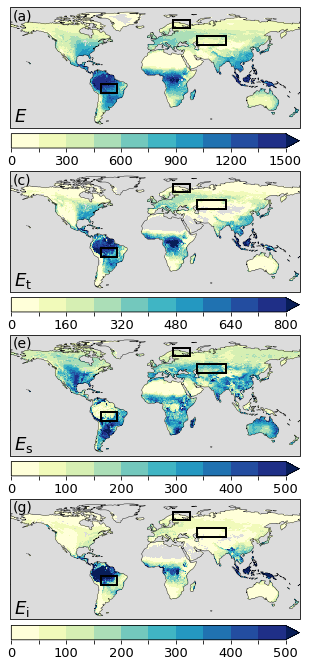

In [37]:
# mean E boxes - v2
# cmap = cmap_map(lambda x: x/1.1, cm.jet_r)
cmap = plt.cm.get_cmap('YlGnBu')

lvls= np.linspace(0,1500,11)
lvls2= np.linspace(0,1500,11)
fig = plt.figure(figsize=(24,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = em1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(a)',(-177,74),size=14)
ax.annotate('$E$',(-175,-53),size=18)
# ax.set_title('(a) $E$ '+str(name1),size=16, loc='left')
cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,800,11)
lvls2= np.linspace(0,800,11)
n = etm1.notnull()
ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = etm1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(c)',(-177,74),size=14)
ax.annotate('$E_\mathrm{t}$',(-175,-53),size=18)
# ax.set_title('(c) $E_{\mathrm{t}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_800)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,500,11)
lvls2= np.linspace(0,500,11)
n = esm1.notnull()
ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = esm1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(e)',(-177,74),size=14)
ax.annotate('$E_\mathrm{s}$',(-175,-53),size=18)
# ax.set_title('(e) $E_{\mathrm{s}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,500,11)
lvls2= np.linspace(0,500,11)
n = eim1.notnull()
ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = eim1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(g)',(-177,74),size=14)
ax.annotate('$E_\mathrm{i}$',(-175,-53),size=18)
# ax.set_title('(g) $E_{\mathrm{i}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/e_mean_{start_year}_{end_year}_{name1}_{name1}_boxes_v2.jpg',dpi=300,bbox_inches='tight')

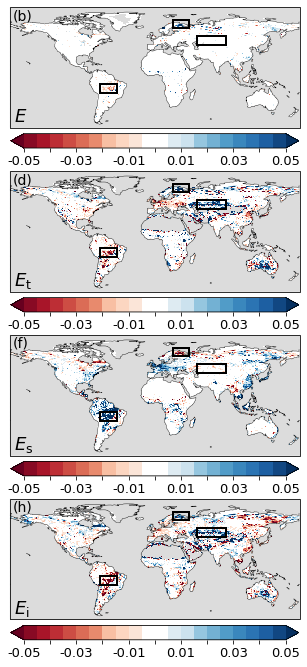

In [38]:
# plot relative difference E boxes
lvls= np.linspace(-0.05,0.05,21)
lvls2= np.linspace(-0.05,0.05,11)
rel=f'({name2}-{name1})/{name1}'

fig = plt.figure(figsize=(24,10))
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = e_c.notnull()
e_c[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = e_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_005)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(b)',(-177,74),size=14)
ax.annotate('$E$',(-175,-53),size=18)
# ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $E$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = et_c.notnull()
et_c[0,0]=0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = et_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_005)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(d)',(-177,74),size=14)
ax.annotate('$E_\mathrm{t}$',(-175,-53),size=18)
# ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{t}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = es_c.notnull()
es_c[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = es_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_005)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(f)',(-177,74),size=14)
ax.annotate('$E_\mathrm{s}$',(-175,-53),size=18)
# ax.set_title('(f) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{s}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
ei_c[0,0]=0.21
n = ei_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ei_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_005)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(h)',(-177,74),size=14)
ax.annotate('$E_\mathrm{i}$',(-175,-53),size=18)
# ax.set_title('(h) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{i}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/e_mean_{start_year}_{end_year}_reldiff_{name2}-{name1}_{name2}-{name1}_boxes_v2.jpg',dpi=300,bbox_inches='tight')

### SOIL MOISTURE - all months

In [39]:
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_monthly.nc')
name1='CTR'
name2='IALC'

sm11 = mod1.SWVL1 
sm12 = mod1.SWVL2 
sm13 = mod1.SWVL3 
sm14 = mod1.SWVL4 
sm1234 = mod1.SWVL234

sm21 = mod2.SWVL1
sm22 = mod2.SWVL2
sm23 = mod2.SWVL3
sm24 = mod2.SWVL4
sm2234 = mod2.SWVL234

sm11m = sm11.mean(dim='time')
sm12m = sm12.mean(dim='time')
sm13m = sm13.mean(dim='time')
sm14m = sm14.mean(dim='time')
sm1234m = sm1234.mean(dim='time')

sm11m = sm11m.where(sm11m>0.01)
sm12m = sm12m.where(sm12m>0.01)
sm13m = sm13m.where(sm13m>0.01)
sm14m = sm14m.where(sm14m>0.01)
sm1234m = sm1234m.where(sm1234m>0.01)

sm1_c = (sm21.mean(dim='time')-sm11m)/sm11m
sm2_c = (sm22.mean(dim='time')-sm12m)/sm12m
sm3_c = (sm23.mean(dim='time')-sm13m)/sm13m
sm4_c = (sm24.mean(dim='time')-sm14m)/sm14m
sm234_c = (sm2234.mean(dim='time')-sm1234m)/sm1234m

In [40]:
def sm_boxes(name1,name2,lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_monthly.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
    name1='CTR'
    name2='IALC'

    sm11 = mod1.SWVL1 
    sm12 = mod1.SWVL2 
    sm13 = mod1.SWVL3 
    sm14 = mod1.SWVL4 
    sm1234 = mod1.SWVL234

    sm21 = mod2.SWVL1
    sm22 = mod2.SWVL2
    sm23 = mod2.SWVL3
    sm24 = mod2.SWVL4
    sm2234 = mod2.SWVL234

    sm11m = sm11.mean(dim=['lat','lon','time']).values
    sm12m = sm12.mean(dim=['lat','lon','time']).values
    sm13m = sm13.mean(dim=['lat','lon','time']).values
    sm14m = sm14.mean(dim=['lat','lon','time']).values
    sm1234m = sm1234.mean(dim=['lat','lon','time']).values
    
    sm21m = sm21.mean(dim=['lat','lon','time']).values
    sm22m = sm22.mean(dim=['lat','lon','time']).values
    sm23m = sm23.mean(dim=['lat','lon','time']).values
    sm24m = sm24.mean(dim=['lat','lon','time']).values
    sm2234m = sm2234.mean(dim=['lat','lon','time']).values

    sm1_c = (sm21m-sm11m)/sm11m
    sm2_c = (sm22m-sm12m)/sm12m
    sm3_c = (sm23m-sm13m)/sm13m
    sm4_c = (sm24m-sm14m)/sm14m
    sm234_c = (sm2234m-sm1234m)/sm1234m

    return np.round(sm11m,3),np.round(sm21m,3),np.round(sm1234m,3),np.round(sm2234m,3),np.round(sm1_c,3),np.round(sm234_c,3)

In [41]:
az = sm_boxes(name1,name2,lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = sm_boxes(name1,name2,lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = sm_boxes(name1,name2,lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)

df = pd.DataFrame(index=['az','lp','as'],columns=['sm11','sm21','sm1234','sm2234','sm1_c','sm234_c'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass
df

,sm11,sm21,sm1234,sm2234,sm1_c,sm234_c
az,0.367,0.362,0.41,0.41,-0.014,-0.001
lp,0.286,0.287,0.283,0.283,0.001,-0.0
as,0.165,0.165,0.24,0.24,0.004,-0.001


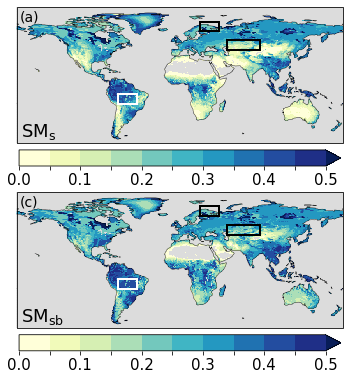

In [42]:
# boxes v2
cmap = plt.cm.get_cmap('YlGnBu')
lvls= np.linspace(0,0.5,11)
lvls2= np.linspace(0,0.5,11)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.5,
                wspace=0.2,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = sm11m.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm11m.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.76)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_05)
ax.annotate('(a)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{s}}$',(-175,-53),size=18)
# ax.set_title('(a) $\mathrm{SM}_{\mathrm{s}}$ '+str(name1),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = sm1234m.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm1234m.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.76)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_05)
ax.annotate('(c)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{sb}}$',(-175,-53),size=18)
# ax.set_title('(c) $\mathrm{SM}_{\mathrm{sb}}$ '+str(name1),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/sm_2_rel_mean_{start_year}_{end_year}_{name1}_{name1}_boxes_v2.jpg',dpi=300,bbox_inches='tight')

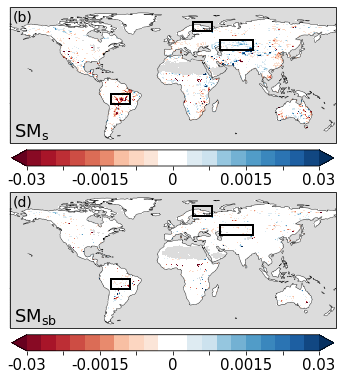

In [43]:
# V2
# cmap = plt.cm.get_cmap('RdBu')
lvls= np.linspace(-0.03,0.03,21)
lvls2= np.linspace(-0.03,0.03,9)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.5,
                wspace=0.2,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = sm1_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm1_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.76)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_003)
ax.annotate('(b)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{s}}$',(-175,-53),size=18)
# ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{s}}$ '+str(rel),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = sm234_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm234_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.76)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_003)
ax.annotate('(d)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{sb}}$',(-175,-53),size=18)
# ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{sb}}$ '+str(rel),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/sm_2_rel_mean_reldiff_{start_year}_{end_year}_{name2}-{name1}_{name2}-{name1}_boxes_v2.jpg',dpi=300,bbox_inches='tight')

### RMSE effects

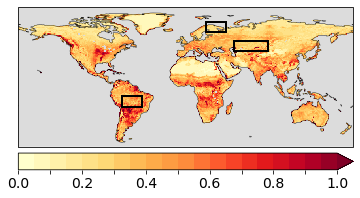

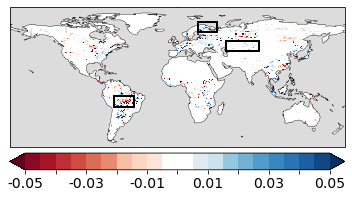

In [44]:
mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
e1 = mod.E * -1000

mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
e2 = mod.E * -1000

ref_data = 'DOLCE_v3'
fol_ref = f'{fol}/data/ref_data'
ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}.nc')
ref = ref.hfls/28.94 # from w/m2 to mm/day

rmse1 = LE_rmse(e1,ref)
rmse2 = LE_rmse(e2,ref)
rmsed = rmse1-rmse2
rmsed[0,0]=-0.04

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0,1,21)
lvls2= np.linspace(0,1,11)
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = rmsed.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_0_1)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.set_title('RMSE $E$ '+str(name1),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/rmse_e_monthly_{start_year}_{end_year}_{name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

lvls= np.linspace(-0.03,0.03,21)
lvls2= np.linspace(-0.03,0.03,11)
tl=['-0.03','','-0.018','','-0.006','','0.006','','0.018','','0.03']
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = rmsed.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmsed.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl_005)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.set_title('$\Delta$RMSE $E$ '+str(name1)+'-'+str(name2),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/rmsediff_e_monthly_{start_year}_{end_year}_{name1}-{name2}_{name1}-{name2}.jpg',dpi=300,bbox_inches='tight')

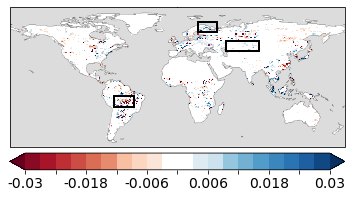

In [45]:
# plot rmse diff with with significance test
ref_data = 'DOLCE_v3'
start_year = '1999'
end_year = '2018'
var = 'hfls'
reps = 1000
tp = 'fullfield'
dt = 'dt_no'
#load quantiles
tp2 = tp.replace(" ", "_")
q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{ref_data}_{start_year}_{end_year}_rmse_{dt}_allmonths.nc')


mod = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
e1 = mod.E * -1000

mod = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
e2 = mod.E * -1000

ref_data = 'DOLCE_v3'
fol_ref = f'{fol}/data/ref_data/'
ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}.nc')
ref = ref.hfls/28.94 # from w/m2 to mm/day

r1 = LE_rmse(e1,ref)
r2 = LE_rmse(e2,ref)
r = r1-r2
r[0,0]=-0.04

# calculate area percentages of results
cube = r.to_iris()
cube.coord('latitude').guess_bounds()
cube.coord('longitude').guess_bounds()
grid_areas = iris.analysis.cartography.area_weights(cube)

# without significance
r = r.where(r.lat>-60) # exclude antarctica
areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
areas = areas.where(areas.lat>-60) # exclude antarctica
a = areas.where(r.notnull()) # all land points areas with data
asum = a.sum().values # total land area with data

ap = areas.where(r>0) # positive correlation diff - improvement
an = areas.where(r<0) # negative correlation diff - deterioration
ap_p = ap.sum().values/a.sum().values # percentage of +
an_p = an.sum().values/a.sum().values # percentage of -

# with significance
rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
areas = areas.where(areas.lat>-60) # exclude antarctica
a = areas.where(r.notnull()) # all land points areas with data
asum = a.sum().values # total land area with data

asig = areas.where(rs2.notnull()) # all land points areas with data
asigsum = asig.sum().values # total land area with data
asigp = asigsum/asum
aps = areas.where(rs2>0) # positive correlation diff - improvement
ans = areas.where(rs2<0) # negative correlation diff - deterioration
aps_p = aps.sum().values/a.sum().values # percentage of +
ans_p = ans.sum().values/a.sum().values # percentage of -
aps_ps = aps.sum().values/asig.sum().values # percentage of +
ans_ps = ans.sum().values/asig.sum().values # percentage of -

# mean + or - delta correlation
rp = r.where(r>0).mean().values
rn = r.where(r<0).mean().values

rps = rs2.where(rs2>0).mean().values
rns = rs2.where(rs2<0).mean().values

rnull = r.isnull()

lvls= np.linspace(-0.03,0.03,21)
lvls2= np.linspace(-0.03,0.03,11)
tl=['-0.03','','-0.018','','-0.006','','0.006','','0.018','','0.03']

# fig with stats
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.2)
n = r.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls2)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl)
ax.set_title(f'',size=14)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
# ax.set_ylim(-20,0)
# ax.set_xlim(-70,-40)

# ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=10)
# ax.annotate(f'+ $\Delta$RMSE sig: {np.int(aps_ps*100)}%',(-177,-38), size=10)
# ax.annotate(f'- $\Delta$RMSE sig: {np.int(ans_ps*100)}%',(-177,-55),size=10)

fig.savefig(f'{fol}/output_figures/landcover/rmsediff_e_monthly_{start_year}_{end_year}_{name1}-{name2}_{name1}-{name2}_sig.jpg',dpi=300,bbox_inches='tight')

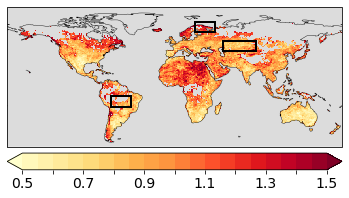

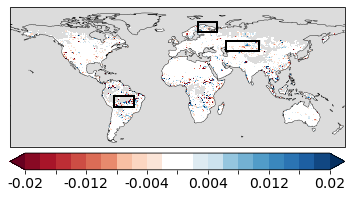

In [46]:
# load anomalies of soil moisture
mod = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
sm1 = mod.SWVL1 

mod = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
sm2 = mod.SWVL1 

sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018-stdia_anomalies.nc')
sm_esa=sm_esa.sm
# we need to mask for temporal coverage of esa data
mask=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018-ia_anomalies_60mask.nc')#mask for 60%ts coverage
mask=mask.sm[72:]
sm_esa = sm_esa.where(mask.notnull())

rmse1 = LE_rmse(sm1,sm_esa)
rmse2 = LE_rmse(sm2,sm_esa)
rmsed = rmse1-rmse2

cmap = plt.cm.get_cmap('YlOrRd')
lvls= np.linspace(0.5,1.5,21)
lvls2= np.linspace(0.5,1.5,11)
tl=['0.5','','0.7','','0.9','','1.1','','1.3','','1.5']
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = rmsed.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmse1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.set_title('RMSE $\mathrm{SM_s}$ std-anomaly '+str(name1),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/rmse_sms_stdanomaly_{start_year}_{end_year}_{name1}_{name1}.jpg',dpi=300,bbox_inches='tight')

lvls= np.linspace(-0.02,0.02,21)
lvls2= np.linspace(-0.02,0.02,11)
tl=['-0.02','','-0.012','','-0.004','','0.004','','0.012','','0.02']
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = rmsed.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = rmsed.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.02, ticks=lvls2)
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_xticklabels(tl)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.set_title('$\Delta$RMSE $\mathrm{SM_s}$ std-anomaly '+str(name1)+'-'+str(name2),size=18,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/rmsediff_sms_stdanomaly_{start_year}_{end_year}_{name1}-{name2}_{name1}-{name2}.jpg',dpi=300,bbox_inches='tight')

In [47]:
def rmse_e_boxes(lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))

    mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
   
    e1 = mod1.E * -1000
    e2 = mod2.E * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data/'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}.nc')
    ref = ref.where((ref.lat>lat_min)&(ref.lat<lat_max)&(ref.lon>lon_min)&(ref.lon<lon_max))
    ref = ref.hfls/28.94 # from w/m2 to mm/day

    rmse1 = LE_rmse(e1,ref).mean(dim=['lat','lon']).values
    rmse2 = LE_rmse(e2,ref).mean(dim=['lat','lon']).values
    rmsed = rmse1-rmse2

    return np.round(rmse1,3),np.round(rmse2,3),np.round(rmsed,3)

In [48]:
def rmse_sms_boxes(lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    
    # load anomalies of soil moisture
    mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))
    sm1 = mod1.SWVL1 

    mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_stdia_anomalies.nc')
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
    sm2 = mod2.SWVL1 

    sm_esa=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018-stdia_anomalies.nc')
    sm_esa=sm_esa.sm
    # we need to mask for temporal coverage of esa data
    mask=xr.open_dataset(f'{fol}/data/ref_data/ESACCI-SOILMOISTURE-1999-2018-ia_anomalies_60mask.nc')#mask for 60%ts coverage
    mask=mask.sm[72:]
    sm_esa = sm_esa.where(mask.notnull())

    rmse1 = LE_rmse(sm1,sm_esa).mean(dim=['lat','lon']).values
    rmse2 = LE_rmse(sm2,sm_esa).mean(dim=['lat','lon']).values
    rmsed = rmse1-rmse2

    return np.round(rmse1,3),np.round(rmse2,3),np.round(rmsed,3)

In [49]:
az = rmse_e_boxes(lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = rmse_e_boxes(lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = rmse_e_boxes(lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)

df = pd.DataFrame(index=['az','lp','as'],columns=['rmse1','rmse2','rmsed'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass
df

,rmse1,rmse2,rmsed
az,0.427,0.436,-0.009
lp,0.278,0.273,0.004
as,0.33,0.328,0.002


In [50]:
az = rmse_sms_boxes(lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = rmse_sms_boxes(lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = rmse_sms_boxes(lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)

df = pd.DataFrame(index=['az','lp','as'],columns=['rmse1','rmse2','rmsed'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass
df

,rmse1,rmse2,rmsed
az,1.006,1.002,0.004
lp,1.324,1.323,0.0
as,0.807,0.807,-0.0


### CORRELATION MAPS

In [51]:
exp_name1,exp_name2='exp3','ex10'
dt='dt_no'

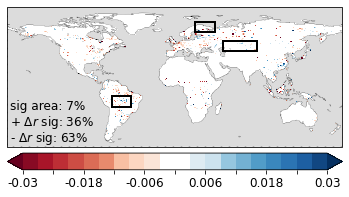

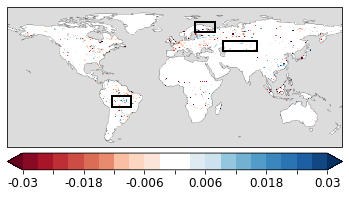

In [52]:
for sig in ['sig_yes']:#,'sig_no']:
    ref_data = 'DOLCE_v3'
    start_year = '1999'
    end_year = '2018'
    var = 'hfls'
    reps = 1000
    tp = 'ia anomalies'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_{tp2}_{ref_data}_{start_year}_{end_year}_corr_{dt}.nc')

    # calculate correlation
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data/'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_ia_anomalies.nc')

    mod1 = xr.open_dataset(f'{f_mod1}/o_efl_{start_year}_{end_year}_ia_anomalies.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/o_efl_{start_year}_{end_year}_ia_anomalies.nc')

    # preprocess - select variable and change units
    d_ref = pp_ref(ref,ref_data)[0]
    d_mod1 = pp_mod(mod1)    
    d_mod2 = pp_mod(mod2)  

    # detrend
    if (dt=='dt_yes'):
        d_refd = detrend_permonth(da=d_ref, dim='time', deg=1)
        d_mod1d = detrend_permonth(da=d_mod1, dim='time', deg=1)
        d_mod2d = detrend_permonth(da=d_mod2, dim='time', deg=1)
    else:
        d_refd=d_ref
        d_mod1d=d_mod1
        d_mod2d=d_mod2
        
    r1=LE_corr(d_refd, d_mod1d)
    r2=LE_corr(d_refd, d_mod2d)
    r = r2-r1
    
    
#     rd=calculate_correlation(fol,ref_data,tp,start_year, end_year,var,exp_name1,exp_name2,dt)
#     r=rd[0]
#     r1=rd[1]
#     r2=rd[2]

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()

    lvls= np.linspace(-0.03,0.03,21)
    lvls3= np.linspace(-0.03,0.03,11)
    lvls2= np.linspace(-0.03,0.03,2)
    tl=['-0.03','','-0.018','','-0.006','','0.006','','0.018','','0.03']

    # fig with stats
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    n = r.notnull()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', hatches=['///'], add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=12)
    ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    cbar.ax.set_xticklabels(tl)
    ax.set_title(f'',size=14)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)

    ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=12)
    ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=12)
    ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=12)
    fig.savefig(f'{fol}/output_figures/corrdiff_E_{name1}_{name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}_stats.jpg',dpi=300,bbox_inches='tight')

    # fig without stats
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    n = r.notnull()
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=12)
    ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    cbar.ax.set_xticklabels(tl)
    ax.set_title(f'',size=14)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/landcover/corrdiff_E_{name1}_{name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_dolce_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')


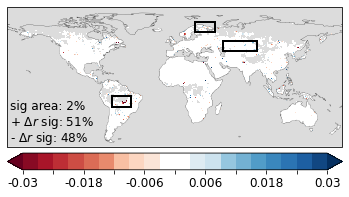

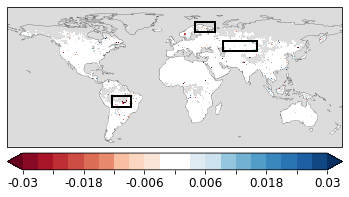

In [53]:
for sig in ['sig_yes']:#,'sig_no']: 
    start_year = '1999'
    end_year = '2018'
    reps=1000
    tp = f'ia anomalies'
    layer='layer1'
    th='60'
    #load quantiles
    tp2 = tp.replace(" ", "_")
    q = xr.open_dataset(f'{fol}/data/htessel_output/sig_files/q_levels/quantiles_reps{reps}_{exp_name1}_{exp_name2}_ia_anomalies_esacci_{start_year}_{end_year}_corr_{dt}_{th}.nc')

    # calculate correlation
    smfol=f'{fol}/data/ref_data'
    if (layer=='layer1'):
        somo=xr.open_dataset(f'{smfol}/ESACCI-SOILMOISTURE-1999-2018-ia_anomalies_{th}mask.nc')
        somo=somo.sm

    # model
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_ia_anomalies.nc')    
    if (layer=='layer1'):
        sm1 = mod1.SWVL1 #* 0.07 * 1e3 # 7cm
        sm2 = mod2.SWVL1 #* 0.07 * 1e3 # 7cm

    # detrend
    if (dt=='dt_yes'):
        sm1_dt = detrend_permonth(sm1, dim='time', deg=1)
        sm2_dt = detrend_permonth(sm2, dim='time', deg=1)
        somo_dt = detrend_permonth(somo, dim='time', deg=1)
        d_mod1=sm1_dt
        d_mod2=sm2_dt
        d_refd=somo_dt
    else:
        sm1_dt=sm1
        sm2_dt=sm2
        somo_dt=somo
        
    r1 = xr.corr(sm1_dt, somo_dt, dim=['time'])
    r2 = xr.corr(sm2_dt, somo_dt, dim=['time'])
    r = r2-r1

    # calculate area percentages of results
    cube = r.to_iris()
    cube.coord('latitude').guess_bounds()
    cube.coord('longitude').guess_bounds()
    grid_areas = iris.analysis.cartography.area_weights(cube)

    # without significance
    r = r.where(r.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    ap = areas.where(r>0) # positive correlation diff - improvement
    an = areas.where(r<0) # negative correlation diff - deterioration
    ap_p = ap.sum().values/a.sum().values # percentage of +
    an_p = an.sum().values/a.sum().values # percentage of -

    # with significance
    rs = r.where((r<q.q_value[4]) & (r>q.q_value[1])) #non sig points
    rs2 = r.where((r>q.q_value[4]) | (r<q.q_value[1])) #5% and 95% sig points

    rs2 = rs2.where(rs2.lat>-60) # exclude antarctica
    areas = xr.DataArray(grid_areas, dims=['lat','lon']) # convert iris cube to xarray
    areas = areas.where(areas.lat>-60) # exclude antarctica
    a = areas.where(r.notnull()) # all land points areas with data
    asum = a.sum().values # total land area with data

    asig = areas.where(rs2.notnull()) # all land points areas with data
    asigsum = asig.sum().values # total land area with data
    asigp = asigsum/asum
    aps = areas.where(rs2>0) # positive correlation diff - improvement
    ans = areas.where(rs2<0) # negative correlation diff - deterioration
    aps_p = aps.sum().values/a.sum().values # percentage of +
    ans_p = ans.sum().values/a.sum().values # percentage of -
    aps_ps = aps.sum().values/asig.sum().values # percentage of +
    ans_ps = ans.sum().values/asig.sum().values # percentage of -

    # mean + or - delta correlation
    rp = r.where(r>0).mean().values
    rn = r.where(r<0).mean().values

    rps = rs2.where(rs2>0).mean().values
    rns = rs2.where(rs2<0).mean().values

    rnull = r.isnull()

    lvls= np.linspace(-0.03,0.03,21)
    lvls3= np.linspace(-0.03,0.03,11)
    lvls2= np.linspace(-0.03,0.03,2)
    tl=['-0.03','','-0.018','','-0.006','','0.006','','0.018','','0.03']

    n = r.notnull()
    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        # cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    cbar.ax.tick_params(labelsize=12)
    cbar.ax.set_xticklabels(tl)
    # ax.set_title(f' anomaly SM correlation diff {name2}-{name1}',size=14)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)

    ax.annotate(f'sig area: {np.int(asigp*100)}%',(-177,-21), size=12)
    ax.annotate(f'+ $\Delta$$r$ sig: {np.int(aps_ps*100)}%',(-177,-38), size=12)
    ax.annotate(f'- $\Delta$$r$ sig: {np.int(ans_ps*100)}%',(-177,-55),size=12)
    fig.savefig(f'{fol}/output_figures/landcover/corrdiff_SM_{name1}_{name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esa-cci_{dt}_{sig}_stats.jpg',dpi=300,bbox_inches='tight')

    fig = plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.2)
    cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
    cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cf = r.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    if (sig=='sig_yes'):
        cf2 = rs.plot.contourf(ax=ax,colors='none', hatches=['.....'], add_colorbar=False) # hatch non significant points
        cf2 = rs.plot(ax=ax, cmap=cmap_white, add_colorbar=False, vmin=0, vmax=5, levels=lvls)#plot all points
    cbar = plt.colorbar(cf, orientation='horizontal',extend='both',label=f'', pad=0.02, ticks=lvls3)
    cbar.ax.tick_params(labelsize=12)
    ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
    ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
    cbar.ax.set_xticklabels(tl)
    ax.set_title(f'',size=14)
    ax.set_ylim(-60,90)
    ax.set_xlim(-180,180)
    fig.savefig(f'{fol}/output_figures/landcover/corrdiff_SM_{name1}_{name2}_{reps}_ia_anomalies_allmonths_{start_year}_{end_year}_esa-cci_{dt}_{sig}.jpg',dpi=300,bbox_inches='tight')


### LAST 5 YEARS EFFECTS

In [54]:
start_year=1999
end_year=2018
exp_name1='exp3'
exp_name2='ex10'
name1 = 'CTR'
name2 = 'IALC'
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
from matplotlib import cm

In [55]:
def e_boxes(name1,name2,lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
    name1='CTR'
    name2='IALC'

    et1 = mod1.TVEG * -1000
    es1 = mod1.ESOIL * -1000
    e1 = mod1.E * -1000
    ei1 = mod1.evatc * -1000

    et2 = mod2.TVEG * -1000
    es2 = mod2.ESOIL * -1000
    e2 = mod2.E * -1000
    ei2 = mod2.evatc * -1000

    etm1 = et1[-60:].mean(dim=['lat','lon','time']).values*365
    esm1 = es1[-60:].mean(dim=['lat','lon','time']).values*365
    eim1 = ei1[-60:].mean(dim=['lat','lon','time']).values*365
    em1 = e1[-60:].mean(dim=['lat','lon','time']).values*365

    etm2 = et2[-60:].mean(dim=['lat','lon','time']).values*365
    esm2 = es2[-60:].mean(dim=['lat','lon','time']).values*365
    eim2 = ei2[-60:].mean(dim=['lat','lon','time']).values*365
    em2 = e2[-60:].mean(dim=['lat','lon','time']).values*365

#     etm1 = etm1.where(etm1>0.1)
#     esm1 = esm1.where(esm1>0.1)
#     eim1 = eim1.where(eim1>0.1)
#     em1 = em1.where(em1>0.1)

#     etmask = etm1.where(etm1>0.1)
#     esmask = esm1.where(esm1>0.1)
#     eimask = eim1.where(eim1>0.1)
#     emask = em1.where(em1>0.1)

    et_c = (etm2-etm1)/etm1
    es_c = (esm2-esm1)/esm1
    ei_c = (eim2-eim1)/eim1
    e_c = (em2-em1)/em1
    return int(em1),int(em2),int(etm1),int(etm2),int(esm1),int(esm2),int(eim1),int(eim2),np.round(e_c,3),np.round(et_c,3),np.round(es_c,3),np.round(ei_c,3)

In [56]:
az = e_boxes(name1,name2,lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = e_boxes(name1,name2,lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = e_boxes(name1,name2,lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)

df = pd.DataFrame(index=['az','lp','as'],columns=['em1','em2','etm1','etm2','esm1','esm2','eim1','eim2','e_c','et_c','es_c','ei_c'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass
df

,em1,em2,etm1,etm2,esm1,esm2,eim1,eim2,e_c,et_c,es_c,ei_c
az,1174,1162,633,615,156,183,384,363,-0.01,-0.028,0.169,-0.055
lp,202,206,43,49,116,112,39,41,0.021,0.129,-0.033,0.044
as,279,280,29,30,222,220,13,13,0.001,0.04,-0.006,0.04


In [57]:
def e_boxes_dolce(lat_min,lat_max,lon_min,lon_max):
    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}.nc')
    ref = ref.hfls/28.94 # from w/m2 to mm/day
    ref = ref.where((ref.lat>lat_min)&(ref.lat<lat_max)&(ref.lon>lon_min)&(ref.lon<lon_max))
    
    e_m = ref[-60:].mean(dim=['lat','lon','time']).values*365
    return(int(e_m))

In [58]:
az = e_boxes_dolce(lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = e_boxes_dolce(lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = e_boxes_dolce(lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)
df = pd.DataFrame(index=['az','lp','as'],columns=['e_dolcev3m'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass

df

,e_dolcev3m
az,1160
lp,252
as,287


In [59]:
def r_e_boxes(lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))

    mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_ia_anomalies.nc')
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
   
    e1 = mod1.E[-60:] * -1000
    e2 = mod2.E[-60:] * -1000

    ref_data = 'DOLCE_v3'
    fol_ref = f'{fol}/data/ref_data'
    ref = xr.open_dataset(f'{fol_ref}/E_{ref_data}_monthly_{start_year}_{end_year}_ia_anomalies.nc')
    ref = ref.where((ref.lat>lat_min)&(ref.lat<lat_max)&(ref.lon>lon_min)&(ref.lon<lon_max))
    ref = ref.hfls[-60:]/28.94 # from w/m2 to mm/day

    r1 = LE_corr(e1,ref).mean(dim=['lat','lon']).values
    r2 = LE_corr(e2,ref).mean(dim=['lat','lon']).values
    rd = r1-r2

    return np.round(r1,3),np.round(r2,3),np.round(rd,3)

In [60]:
def r_sms_boxes(lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))

    mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_ia_anomalies.nc')
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
   
    sm1 = mod1.SWVL1[-60:]
    sm2 = mod2.SWVL1[-60:]

    smfol=f'{fol}/data/ref_data'
    esa=xr.open_dataset(f'{smfol}/ESACCI-SOILMOISTURE-1999-2018-ia_anomalies.nc')
    esa = esa.where((esa.lat>lat_min)&(esa.lat<lat_max)&(esa.lon>lon_min)&(esa.lon<lon_max))
    esa=esa.sm[-60:]

    r1 = LE_corr(sm1,esa).mean(dim=['lat','lon'],skipna=True).values
    r2 = LE_corr(sm2,esa).mean(dim=['lat','lon'],skipna=True).values
    rd = r2-r1

    return np.round(r1,3),np.round(r2,3),np.round(rd,3)

In [61]:
az = r_e_boxes(lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = r_e_boxes(lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = r_e_boxes(lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)
df = pd.DataFrame(index=['az','lp','as'],columns=['r1','r2','rd'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass

df

,r1,r2,rd
az,0.65,0.649,0.001
lp,0.749,0.749,0.0
as,0.72,0.723,-0.002


In [62]:
az = r_sms_boxes(lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = r_sms_boxes(lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = r_sms_boxes(lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)
df = pd.DataFrame(index=['az','lp','as'],columns=['r1','r2','rd'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass

df

,r1,r2,rd
az,0.566,0.569,0.003
lp,-0.033,-0.037,-0.004
as,0.656,0.656,0.001


In [63]:
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_wat_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_wat_{start_year}_{end_year}_monthly.nc')
name1='CTR'
name2='IALC'

et1 = mod1.TVEG * -1000
es1 = mod1.ESOIL * -1000
e1 = mod1.E * -1000
ei1 = mod1.evatc * -1000

et2 = mod2.TVEG * -1000
es2 = mod2.ESOIL * -1000
e2 = mod2.E * -1000
ei2 = mod2.evatc * -1000

etm1 = et1[-60:].mean(dim='time')*365
esm1 = es1[-60:].mean(dim='time')*365
eim1 = ei1[-60:].mean(dim='time')*365
em1 = e1[-60:].mean(dim='time')*365

etm2 = et2[-60:].mean(dim='time')*365
esm2 = es2[-60:].mean(dim='time')*365
eim2 = ei2[-60:].mean(dim='time')*365
em2 = e2[-60:].mean(dim='time')*365

etm1 = etm1.where(etm1>0.1)
esm1 = esm1.where(esm1>0.1)
eim1 = eim1.where(eim1>0.1)
em1 = em1.where(em1>0.1)

etmask = etm1.where(etm1>0.1)
esmask = esm1.where(esm1>0.1)
eimask = eim1.where(eim1>0.1)
emask = em1.where(em1>0.1)

et_c = (etm2-etm1)/etm1
es_c = (esm2-esm1)/esm1
ei_c = (eim2-eim1)/eim1
e_c = (em2-em1)/em1

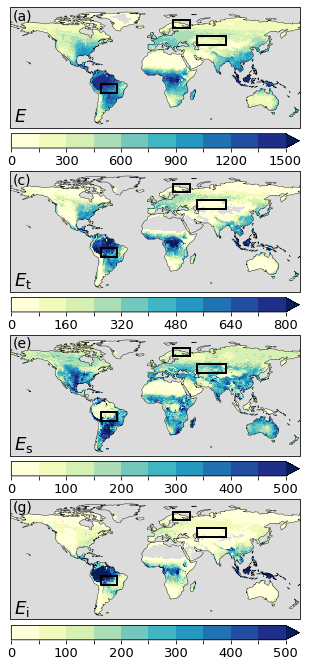

In [64]:
# mean E boxes - v2
cmap = plt.cm.get_cmap('YlGnBu')

lvls= np.linspace(0,1500,11)
lvls2= np.linspace(0,1500,11)
fig = plt.figure(figsize=(24,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = em1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(a)',(-177,74),size=14)
ax.annotate('$E$',(-175,-53),size=18)
# ax.set_title('(a) $E$ '+str(name1),size=16, loc='left')
cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,800,11)
lvls2= np.linspace(0,800,11)
n = etm1.notnull()
ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = etm1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(c)',(-177,74),size=14)
ax.annotate('$E_\mathrm{t}$',(-175,-53),size=18)
# ax.set_title('(c) $E_{\mathrm{t}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_800)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,500,11)
lvls2= np.linspace(0,500,11)
n = esm1.notnull()
ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = esm1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(e)',(-177,74),size=14)
ax.annotate('$E_\mathrm{s}$',(-175,-53),size=18)
# ax.set_title('(e) $E_{\mathrm{s}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,500,11)
lvls2= np.linspace(0,500,11)
n = eim1.notnull()
ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = eim1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.34)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(g)',(-177,74),size=14)
ax.annotate('$E_\mathrm{i}$',(-175,-53),size=18)
# ax.set_title('(g) $E_{\mathrm{i}}$ '+str(name1),size=16,loc='left')
cbar.ax.set_xticklabels(tl_500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/e_mean_{start_year}_{end_year}_{name1}_{name1}_boxes_v2_2014_2018.jpg',dpi=300,bbox_inches='tight')

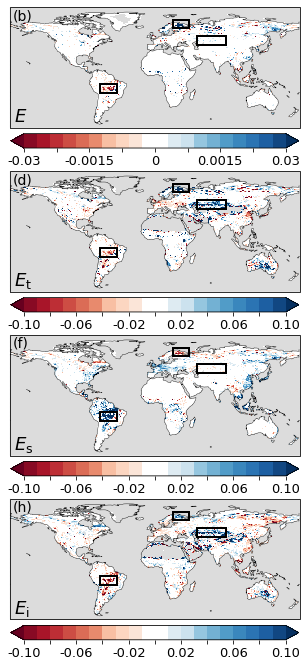

In [65]:
# plot relative difference E boxes
lvls= np.linspace(-0.05,0.05,21)
lvls2= np.linspace(-0.05,0.05,11)
rel=f'({name2}-{name1})/{name1}'
lvls= np.linspace(-0.03,0.03,21)
lvls2= np.linspace(-0.03,0.03,9)
fig = plt.figure(figsize=(24,10))
ax = plt.subplot(411,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = e_c.notnull()
e_c[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = e_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_003)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(b)',(-177,74),size=14)
ax.annotate('$E$',(-175,-53),size=18)
# ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $E$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(-0.1,0.1,21)
lvls2= np.linspace(-0.1,0.1,11)

ax = plt.subplot(412,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = et_c.notnull()
et_c[0,0]=0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = et_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_01)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(d)',(-177,74),size=14)
ax.annotate('$E_\mathrm{t}$',(-175,-53),size=18)
# ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{t}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(413,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = es_c.notnull()
es_c[0,0]=-0.21
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = es_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_01)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(f)',(-177,74),size=14)
ax.annotate('$E_\mathrm{s}$',(-175,-53),size=18)
# ax.set_title('(f) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{s}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(414,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
ei_c[0,0]=0.21
n = ei_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ei_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.34)
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_xticklabels(tl_01)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.annotate('(h)',(-177,74),size=14)
ax.annotate('$E_\mathrm{i}$',(-175,-53),size=18)
# ax.set_title('(h) $\Delta_{\mathrm{rel}}$ $E_{\mathrm{i}}$ '+str(rel),size=16,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/e_mean_{start_year}_{end_year}_reldiff_{name2}-{name1}_{name2}-{name1}_boxes_v2_2014_2018.jpg',dpi=300,bbox_inches='tight')

### EVAPORATION VS DOLCE MEAN

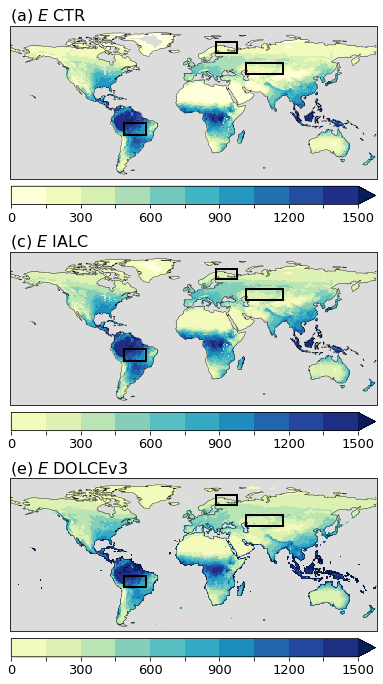

In [66]:
cmap = plt.cm.get_cmap('YlGnBu')

lvls= np.linspace(0,1500,11)
lvls2= np.linspace(0,1500,11)
fig = plt.figure(figsize=(24,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.subplot(311,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.2)
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = em1.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(a)',(-177,74),size=14)
# ax.annotate('$E$ CTR',(-175,-53),size=18)
ax.set_title('(a) $E$ CTR',size=16,loc='left')
cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,1500,11)
lvls2= np.linspace(0,1500,11)
n = etm1.notnull()
ax = plt.subplot(312,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = em2.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(c)',(-177,74),size=14)
# ax.annotate('$E$ IALC',(-175,-53),size=18)
ax.set_title('(c) $E$ IALC',size=16,loc='left')
cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(0,1500,11)
lvls2= np.linspace(0,1500,11)
n = etm1.notnull()
ax = plt.subplot(313,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = em_dolce.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(e)',(-177,74),size=14)
# ax.annotate('$E$ DOLCEv3',(-175,-53),size=18)
ax.set_title('(e) $E$ DOLCEv3',size=16,loc='left')
cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

fig.savefig(f'{fol}/output_figures/landcover/e_mean_ctr_ialc_dolce.jpg',dpi=300,bbox_inches='tight')

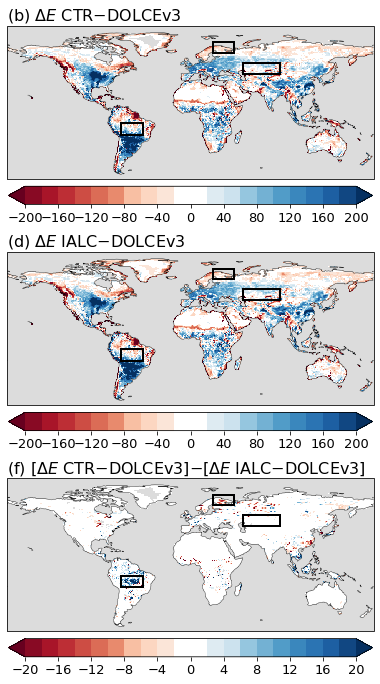

In [67]:
ed1 = em1 - em_dolce
ed2 = em2 - em_dolce
edd = ed1 - ed2

lvls= np.linspace(-200,200,21)
lvls2= np.linspace(-200,200,11)
fig = plt.figure(figsize=(24,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.subplot(311,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.2)
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ed1.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='both', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(a)',(-177,74),size=14)
# ax.annotate('$E$ CTR',(-175,-53),size=18)
ax.set_title('(b) $\Delta$$E$ CTR$-$DOLCEv3',size=16,loc='left')
# cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(312,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ed2.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='both', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(a)',(-177,74),size=14)
# ax.annotate('$E$ CTR',(-175,-53),size=18)
ax.set_title('(d) $\Delta$$E$ IALC$-$DOLCEv3',size=16,loc='left')
# cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(-20,20,21)
lvls2= np.linspace(-20,20,11)
ax = plt.subplot(313,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = edd.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='both', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(a)',(-177,74),size=14)
# ax.annotate('$E$ CTR',(-175,-53),size=18)
ax.set_title('(f) [$\Delta$$E$ CTR$-$DOLCEv3]$-$[$\Delta$$E$ IALC$-$DOLCEv3]',size=16,loc='left')
# cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

fig.savefig(f'{fol}/output_figures/landcover/e_mean_absdiff_ctr_ialc_dolce.jpg',dpi=300,bbox_inches='tight')

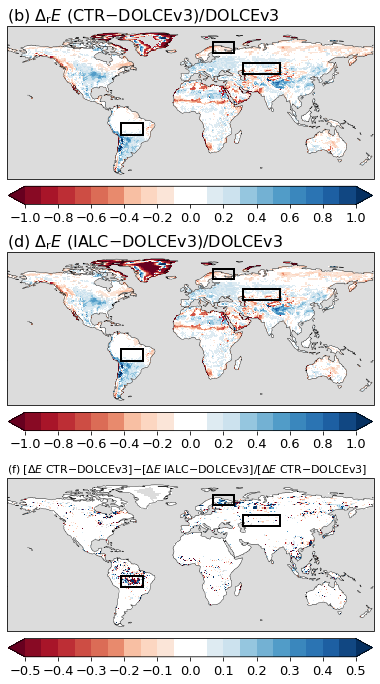

In [68]:
ed1 = (em1 - em_dolce)/em_dolce
ed2 = (em2 - em_dolce)/em_dolce
edd = ((em1 - em_dolce) - (em2 - em_dolce)) / (em1 - em_dolce)

lvls= np.linspace(-1,1,21)
lvls2= np.linspace(-1,1,11)
fig = plt.figure(figsize=(24,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.subplot(311,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.9,
                wspace=0.1,
                hspace=0.2)
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ed1.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='both', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(a)',(-177,74),size=14)
# ax.annotate('$E$ CTR',(-175,-53),size=18)
ax.set_title('(b) $\Delta_{\mathrm{r}}$$E$ (CTR$-$DOLCEv3)/DOLCEv3',size=16,loc='left')
# cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(312,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = ed2.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='both', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(a)',(-177,74),size=14)
# ax.annotate('$E$ CTR',(-175,-53),size=18)
ax.set_title('(d) $\Delta_{\mathrm{r}}$$E$ (IALC$-$DOLCEv3)/DOLCEv3',size=16,loc='left')
# cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

lvls= np.linspace(-0.5,0.5,21)
lvls2= np.linspace(-0.5,0.5,11)
ax = plt.subplot(313,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = em1.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = edd.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='both', shrink=0.43)
cbar.ax.tick_params(labelsize=13)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
# ax.annotate('(a)',(-177,74),size=14)
# ax.annotate('$E$ CTR',(-175,-53),size=18)
ax.set_title('(f) [$\Delta$$E$ CTR$-$DOLCEv3]$-$[$\Delta$$E$ IALC$-$DOLCEv3]/[$\Delta$$E$ CTR$-$DOLCEv3]',size=11,loc='left')
# cbar.ax.set_xticklabels(tl_1500)
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

fig.savefig(f'{fol}/output_figures/landcover/e_mean_reldiff_ctr_ialc_dolce.jpg',dpi=300,bbox_inches='tight')

### SOIL MOISTURE - all months

In [69]:
f_mod1 = f'{fol}/data/htessel_output/{name1}'
f_mod2 = f'{fol}/data/htessel_output/{name2}'
mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_monthly.nc')
mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_monthly.nc')
name1='CTR'
name2='IALC'

sm11 = mod1.SWVL1[-60:] 
sm12 = mod1.SWVL2[-60:] 
sm13 = mod1.SWVL3[-60:] 
sm14 = mod1.SWVL4[-60:] 
sm1234 = mod1.SWVL234[-60:]

sm21 = mod2.SWVL1[-60:]
sm22 = mod2.SWVL2[-60:]
sm23 = mod2.SWVL3[-60:]
sm24 = mod2.SWVL4[-60:]
sm2234 = mod2.SWVL234[-60:]

sm11m = sm11.mean(dim='time')
sm12m = sm12.mean(dim='time')
sm13m = sm13.mean(dim='time')
sm14m = sm14.mean(dim='time')
sm1234m = sm1234.mean(dim='time')

sm11m = sm11m.where(sm11m>0.01)
sm12m = sm12m.where(sm12m>0.01)
sm13m = sm13m.where(sm13m>0.01)
sm14m = sm14m.where(sm14m>0.01)
sm1234m = sm1234m.where(sm1234m>0.01)

sm1_c = (sm21.mean(dim='time')-sm11m)/sm11m
sm2_c = (sm22.mean(dim='time')-sm12m)/sm12m
sm3_c = (sm23.mean(dim='time')-sm13m)/sm13m
sm4_c = (sm24.mean(dim='time')-sm14m)/sm14m
sm234_c = (sm2234.mean(dim='time')-sm1234m)/sm1234m

In [70]:
def sm_boxes(name1,name2,lat_min,lat_max,lon_min,lon_max):
    f_mod1 = f'{fol}/data/htessel_output/{name1}'
    f_mod2 = f'{fol}/data/htessel_output/{name2}'
    mod1 = xr.open_dataset(f'{f_mod1}/o_soil_{start_year}_{end_year}_monthly.nc')
    mod2 = xr.open_dataset(f'{f_mod2}/o_soil_{start_year}_{end_year}_monthly.nc')
    mod1 = mod1.where((mod1.lat>lat_min)&(mod1.lat<lat_max)&(mod1.lon>lon_min)&(mod1.lon<lon_max))
    mod2 = mod2.where((mod2.lat>lat_min)&(mod2.lat<lat_max)&(mod2.lon>lon_min)&(mod2.lon<lon_max))
    name1='CTR'
    name2='IALC'

    sm11 = mod1.SWVL1[-60:] 
    sm12 = mod1.SWVL2[-60:] 
    sm13 = mod1.SWVL3[-60:] 
    sm14 = mod1.SWVL4[-60:] 
    sm1234 = mod1.SWVL234[-60:]

    sm21 = mod2.SWVL1[-60:]
    sm22 = mod2.SWVL2[-60:]
    sm23 = mod2.SWVL3[-60:]
    sm24 = mod2.SWVL4[-60:]
    sm2234 = mod2.SWVL234[-60:]

    sm11m = sm11.mean(dim=['lat','lon','time']).values
    sm12m = sm12.mean(dim=['lat','lon','time']).values
    sm13m = sm13.mean(dim=['lat','lon','time']).values
    sm14m = sm14.mean(dim=['lat','lon','time']).values
    sm1234m = sm1234.mean(dim=['lat','lon','time']).values
    
    sm21m = sm21.mean(dim=['lat','lon','time']).values
    sm22m = sm22.mean(dim=['lat','lon','time']).values
    sm23m = sm23.mean(dim=['lat','lon','time']).values
    sm24m = sm24.mean(dim=['lat','lon','time']).values
    sm2234m = sm2234.mean(dim=['lat','lon','time']).values

    sm1_c = (sm21m-sm11m)/sm11m
    sm2_c = (sm22m-sm12m)/sm12m
    sm3_c = (sm23m-sm13m)/sm13m
    sm4_c = (sm24m-sm14m)/sm14m
    sm234_c = (sm2234m-sm1234m)/sm1234m

    return np.round(sm11m,3),np.round(sm21m,3),np.round(sm1234m,3),np.round(sm2234m,3),np.round(sm1_c,3),np.round(sm234_c,3)

In [71]:
az = sm_boxes(name1,name2,lat_minb_az,lat_maxb_az,lon_minb2_az,lon_maxb2_az)
lp = sm_boxes(name1,name2,lat_minb_lp,lat_maxb_lp,lon_minb2_lp,lon_maxb2_lp)
ass = sm_boxes(name1,name2,lat_minb_as,lat_maxb_as,lon_minb2_as,lon_maxb2_as)

df = pd.DataFrame(index=['az','lp','as'],columns=['sm11','sm21','sm1234','sm2234','sm1_c','sm234_c'])
df.loc['az'] = az
df.loc['lp'] = lp
df.loc['as'] = ass
df

,sm11,sm21,sm1234,sm2234,sm1_c,sm234_c
az,0.367,0.362,0.411,0.411,-0.016,-0.001
lp,0.286,0.286,0.284,0.284,0.001,0.0
as,0.181,0.182,0.249,0.248,0.005,-0.001


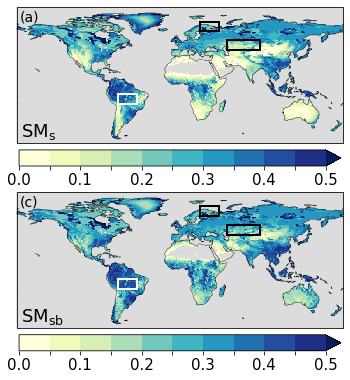

In [72]:
# boxes v2
cmap = plt.cm.get_cmap('YlGnBu')
lvls= np.linspace(0,0.5,11)
lvls2= np.linspace(0,0.5,11)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.5,
                wspace=0.2,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = sm11m.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm11m.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.76)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_05)
ax.annotate('(a)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{s}}$',(-175,-53),size=18)
# ax.set_title('(a) $\mathrm{SM}_{\mathrm{s}}$ '+str(name1),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = sm1234m.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm1234m.plot(ax=ax, cmap=cmap, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2,extend='max', shrink=0.76)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'w-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_05)
ax.annotate('(c)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{sb}}$',(-175,-53),size=18)
# ax.set_title('(c) $\mathrm{SM}_{\mathrm{sb}}$ '+str(name1),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/sm_2_rel_mean_{start_year}_{end_year}_{name1}_{name1}_boxes_v2_2014_2018.jpg',dpi=300,bbox_inches='tight')

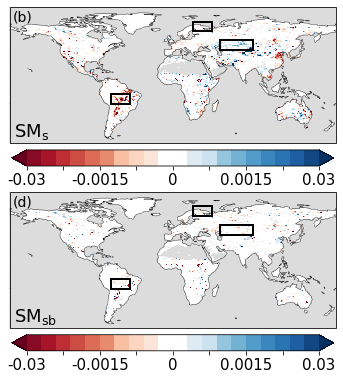

In [73]:
# V2
# cmap = plt.cm.get_cmap('RdBu')
lvls= np.linspace(-0.03,0.03,21)
lvls2= np.linspace(-0.03,0.03,9)
fig = plt.figure(figsize=(12,10))
ax = plt.subplot(211,projection=ccrs.PlateCarree())
plt.subplots_adjust(left=0.01,
                bottom=0.01,
                right=0.5,
                top=0.5,
                wspace=0.2,
                hspace=0.1)
ax.coastlines(linewidth=0.4)
n = sm1_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm1_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.76)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_003)
ax.annotate('(b)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{s}}$',(-175,-53),size=18)
# ax.set_title('(b) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{s}}$ '+str(rel),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)

ax = plt.subplot(212,projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.4)
n = sm234_c.notnull()
cf2 = n.plot.contourf(ax=ax, colors='gainsboro', add_colorbar=False)
cf3 = mn.plot(ax=ax, cmap=cmap_grey, add_colorbar=False, vmin=0, vmax=5, levels=[0,1])
cf = sm234_c.plot(ax=ax, cmap=cmap_rdbu, add_colorbar=False, vmin=0, vmax=5, levels=lvls)
cbar = plt.colorbar(cf, orientation='horizontal',label=f'', pad=0.04, ticks=lvls2, shrink=0.76)
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_maxb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_maxb_az2],[lat_minb_az2,lat_minb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_az2,lon_minb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_maxb_az2,lon_maxb_az2],[lat_minb_az2,lat_maxb_az2],'k-',linewidth=2,linestyle='-')
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_maxb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_minb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_lp2,lon_minb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_lp2,lon_maxb_lp2],[lat_minb_lp2,lat_maxb_lp2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_maxb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_maxb_as2],[lat_minb_as2,lat_minb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_minb_as2,lon_minb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
ax.plot([lon_maxb_as2,lon_maxb_as2],[lat_minb_as2,lat_maxb_as2],color='k',linestyle='-',linewidth=2)
cbar.ax.tick_params(labelsize=15)
cbar.ax.set_xticklabels(tl_003)
ax.annotate('(d)',(-177,74),size=14)
ax.annotate('$\mathrm{SM}_{\mathrm{sb}}$',(-175,-53),size=18)
# ax.set_title('(d) $\Delta_{\mathrm{rel}}$ $\mathrm{SM}_{\mathrm{sb}}$ '+str(rel),size=20,loc='left')
ax.set_ylim(-60,90)
ax.set_xlim(-180,180)
fig.savefig(f'{fol}/output_figures/landcover/sm_2_rel_mean_reldiff_{start_year}_{end_year}_{name2}-{name1}_{name2}-{name1}_boxes_v2_2014_2018.jpg',dpi=300,bbox_inches='tight')